In [27]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [29]:
img_size = (299, 299)
batch_size = 32

In [30]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [31]:
data_dir = "dataset"
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 4


In [32]:
vgg = models.vgg19(pretrained=True)
inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
inception.aux_logits = False 
resnet = models.resnet50(pretrained=True)

In [33]:
for model in [vgg, inception, resnet]:
    for param in model.parameters():
        param.requires_grad = False

In [34]:
vgg_fc = vgg.classifier[0].in_features
vgg.classifier = nn.Sequential(nn.Linear(vgg_fc, 512), nn.ReLU(), nn.Linear(512, num_classes))

inception_fc = inception.fc.in_features
inception.fc = nn.Sequential(nn.Linear(inception_fc, 512), nn.ReLU(), nn.Linear(512, num_classes))

resnet_fc = resnet.fc.in_features
resnet.fc = nn.Sequential(nn.Linear(resnet_fc, 512), nn.ReLU(), nn.Linear(512, num_classes))

vgg, inception, resnet = vgg.to(device), inception.to(device), resnet.to(device)

In [35]:
class EnsembleModel(nn.Module):
    def __init__(self, vgg, inception, resnet, num_classes):
        super(EnsembleModel, self).__init__()
        self.vgg = vgg
        self.inception = inception
        self.resnet = resnet
        self.fc = nn.Linear(3 * num_classes, num_classes)
        
    def forward(self, x):
        vgg_out = self.vgg(x)
        inception_out = self.inception(x)
        resnet_out = self.resnet(x)

        combined = torch.cat((vgg_out, inception_out, resnet_out), dim=1)
        return self.fc(combined)

In [36]:
model = EnsembleModel(vgg, inception, resnet, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Validation Accuracy: {val_acc:.2f}%\n")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model, "best_model.pth")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.show()

Epoch [1/50], Loss: 39.6355, Train Accuracy: 76.63%
Validation Accuracy: 89.33%

Epoch [2/50], Loss: 11.1664, Train Accuracy: 93.80%
Validation Accuracy: 95.65%

Epoch [3/50], Loss: 7.3311, Train Accuracy: 95.75%
Validation Accuracy: 92.49%

Epoch [4/50], Loss: 10.0960, Train Accuracy: 93.95%
Validation Accuracy: 92.49%

Epoch [5/50], Loss: 5.2763, Train Accuracy: 97.13%
Validation Accuracy: 97.63%

Epoch [6/50], Loss: 4.4233, Train Accuracy: 97.23%
Validation Accuracy: 94.47%

Epoch [7/50], Loss: 4.6971, Train Accuracy: 97.64%
Validation Accuracy: 94.47%

Epoch [8/50], Loss: 4.0720, Train Accuracy: 97.39%
Validation Accuracy: 96.44%

Epoch [9/50], Loss: 3.3197, Train Accuracy: 98.05%
Validation Accuracy: 98.02%

Epoch [10/50], Loss: 3.0684, Train Accuracy: 97.90%
Validation Accuracy: 97.23%

Epoch [11/50], Loss: 2.7249, Train Accuracy: 98.56%
Validation Accuracy: 95.26%

Epoch [12/50], Loss: 2.6001, Train Accuracy: 98.46%
Validation Accuracy: 96.84%

Epoch [13/50], Loss: 2.0055, Train

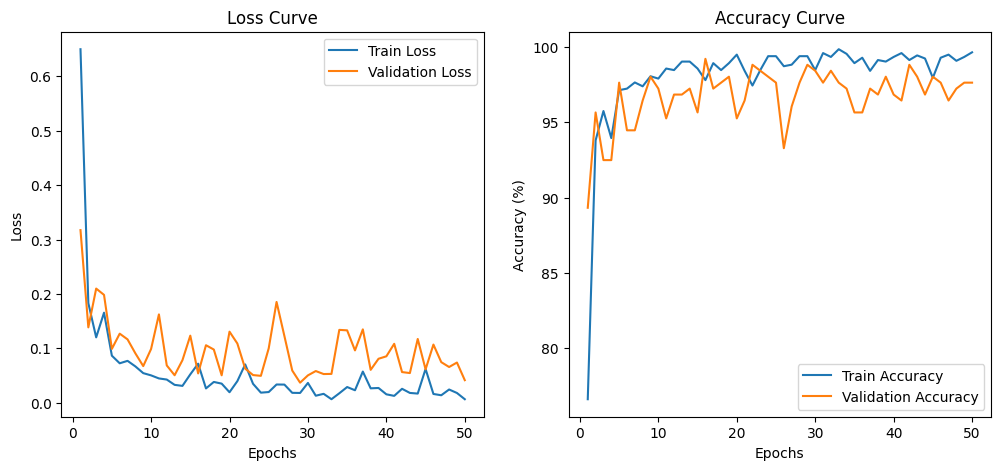

In [38]:
train_model(model, train_loader, val_loader, criterion, optimizer)